In [1]:
import numpy as np
import pandas as pd
import pyarrow
import fastparquet
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Base path to data files
data_path = '../13. Data from R 50000/'

# Load the datasets
X_train = pd.read_parquet(data_path + 'X_train_2024.parquet', engine='pyarrow')
X_test = pd.read_parquet(data_path + 'X_test_2024.parquet', engine='pyarrow')

# List of categorical variables
categorical_vars = ["MARITALSTATUS", "NOOFCHILDREN", "HOMEOWNERIND", "VEHICLE_LEFTORRIGHTHANDDRIVE",
                    "DRIVER1_LICENCETYPE", "DRIVER2_LICENCETYPE", "DRIVER3_LICENCETYPE", "DRIVER4_LICENCETYPE",
                    "DRIVER1_OTHERVEHICLEOWNEDIND", "DRIVER2_OTHERVEHICLEOWNEDIND", "DRIVER3_OTHERVEHICLEOWNEDIND",
                    "DRIVER4_OTHERVEHICLEOWNEDIND", "MONTHLYPAYMENTSIND", "VEHICLE_USE_TYPE", "VEHICLEOVERNIGHTLOCATION",
                    "VEHICLE_OWNERSHIP", "VEHICLE_MODIFIEDIND", "VEHICLE_BODYTYPE", "VEHICLE_FUELTYPE",
                    "VEHICLE_TRANSMISSIONTYPE", "INDICATOR_NRCONVICTIONS_RECENT", "INDICATOR_CLAIMSCOUNT_RECENT"]

# Define numerical columns by excluding categorical ones
numerical_vars = [col for col in X_train.columns if col not in categorical_vars]

# Load y_train and y_test
y_train = pd.read_parquet(data_path + 'y_train_2024.parquet').iloc[:, 0]
y_test = pd.read_parquet(data_path + 'y_test_2024.parquet').iloc[:, 0]

In [2]:
# Train the XGBoost model
model = XGBRegressor(random_state=2024)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmspe = np.sqrt(np.mean(np.square((y_test - y_pred) / y_test))) * 100
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')
print(f'Root Mean Squared Percentage Error: {rmspe:.2f}%')
print(f'R-squared: {r2:.2f}')

# Function to calculate percentage within tolerance
def calculate_within_tolerance(y_true, y_pred, tolerance):
    within_tolerance = abs(y_true - y_pred) / y_true <= tolerance
    percentage_within_tolerance = within_tolerance.mean() * 100
    return percentage_within_tolerance

# Apply the function to the evaluation part
within_10_percent = calculate_within_tolerance(y_test, y_pred, 0.10)
within_50_percent = calculate_within_tolerance(y_test, y_pred, 0.50)
within_100_percent = calculate_within_tolerance(y_test, y_pred, 1.00)

# Print percentage within tolerance
print(f'Percentage within 10%: {within_10_percent:.2f}%')
print(f'Percentage within 50%: {within_50_percent:.2f}%')
print(f'Percentage within 100%: {within_100_percent:.2f}%')

Mean Squared Error: 98826.6534220301
Mean Absolute Error: 211.61756364376828
Root Mean Squared Error: 314.36706796678004
Mean Absolute Percentage Error: 23.91%
Root Mean Squared Percentage Error: 33.71%
R-squared: 0.78
Percentage within 10%: 30.18%
Percentage within 50%: 89.72%
Percentage within 100%: 98.40%


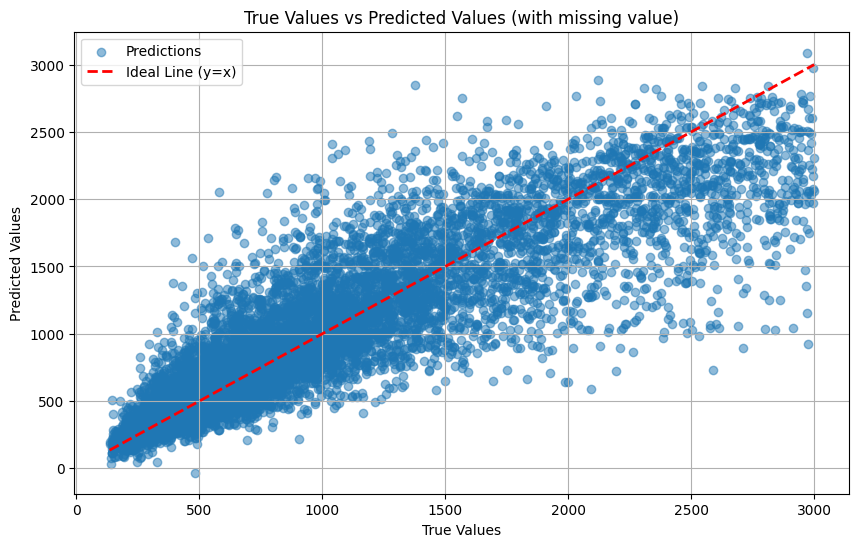

In [3]:
# Scatter plot of true values vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line (y=x)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs Predicted Values (with missing value)')
plt.legend()
plt.grid(True)
plt.show()

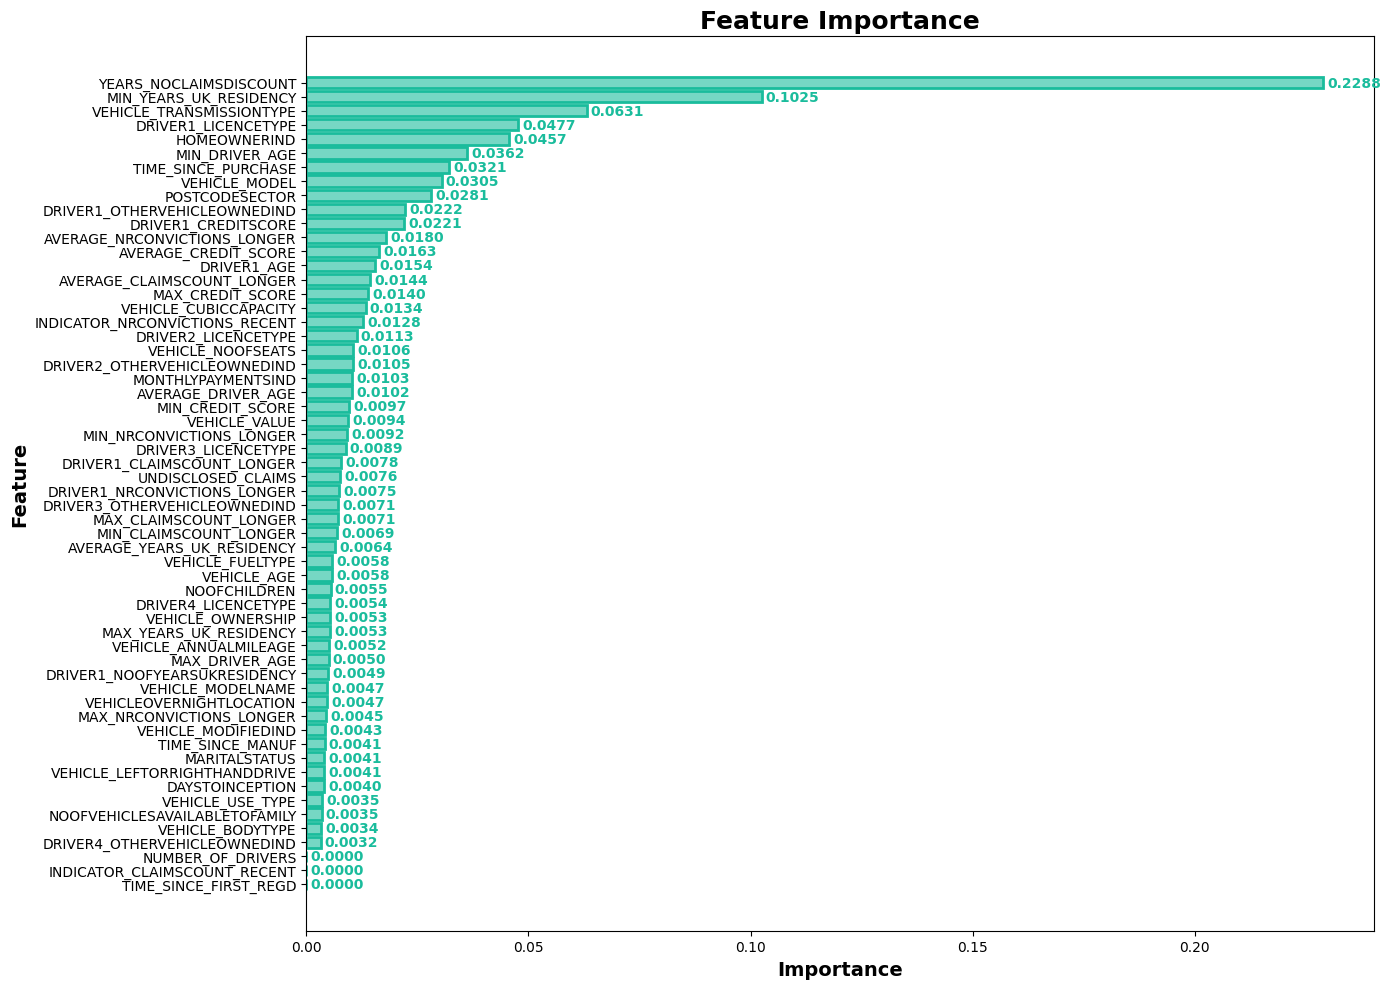

In [8]:
# Feature importance of XGBoost
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
fig, ax = plt.subplots(figsize=(14, 10))

# Gentle color palette
color_importance = '#76D7C4'  # Light green with an edge color
edge_color_importance = '#1ABC9C'  # A slightly darker shade for edges

# Plotting the feature importance
rects = ax.barh(importance_df['Feature'], importance_df['Importance'], color=color_importance, edgecolor=edge_color_importance, linewidth=2)

# Adding titles and labels
ax.set_xlabel('Importance', fontsize=14, weight='bold')
ax.set_ylabel('Feature', fontsize=14, weight='bold')
ax.set_title('Feature Importance', fontsize=18, weight='bold')
ax.invert_yaxis()  # Invert y-axis to have the highest importance at the top

# Attach a text label next to each bar, displaying its importance value
def autolabel(rects, ax, color):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.4f}',  # Adjust precision here if needed
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center',
                    fontsize=10,
                    color=color,
                    weight='bold')

autolabel(rects, ax, '#1ABC9C')  # Matching label color to edge color

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()
